## Langmuir-enhanced entrainment

This notebook compares different schemes to LES in simulating the rate of change in potential energy in the entrainment cases of [Li and Fox-Kemper, 2017](https://doi.org/10.1175/JPO-D-17-0085.1).

GOTM simulations with different schemes were conducted using the initial conditions and surface forcing conditions of Case S-L1 and Case S-B in [Li and Fox-Kemper, 2017](https://doi.org/10.1175/JPO-D-17-0085.1) (see their Table~1).
These are idealized conditions with an initial mixed layer depth, constant wind, waves and destabilzing surface forcing.
All the simulations run for 48~hours.

This set of simulations focuses on the weak to moderate entrainment processes under constant wind, wave and destabilizing surface  buoyancy conditions.

In [1]:
import sys
import os
import subprocess as sp
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import *
np.seterr(all='raise')
%matplotlib inline

In [2]:
# constants
# gravity (m/s^2)
g = 9.81;
# water density (kg/m^3)
rho = 1000;
# specific heat of water (J/Kg/K)
cp = 4200;
# temperature expansion coefficent (K^{-1})
alpha = 1/5000;
# Coriolis parameter (s^{-1})
f = 4*np.pi/86400*np.sin(np.pi/4)
# Inertial period (s)
Ti = 2*np.pi/f

# paths
lf17_root = '/Volumes/scratch/data/NCARLES/archive_les/hist'
# lf17_root = os.environ['HOME']+'/data/NCARLES/archive_les/hist'
lf17_s1_root = os.environ['HOME']+'/data/NCARLES/AnalyzeSingleCase'
gotm_root = os.environ['GOTMRUN_ROOT']+'/LF17'
fig_root = os.environ['GOTMFIG_ROOT']+'/LF17'

os.makedirs(fig_root, exist_ok=True)

casename_list = [
                 'BF05WD05WV00',
                 'BF05WD05WV01',
                 'BF05WD05WV02',
                 'BF05WD05WV03',
                 'BF05WD05WV04',
                 'BF05WD08WV00',
                 'BF05WD08WV01',
                 'BF05WD08WV02',
                 'BF05WD08WV03',
                 'BF05WD08WV04',
                 'BF05WD10WV00',
                 'BF05WD10WV01',
                 'BF05WD10WV02',
                 'BF05WD10WV03',
                 'BF05WD10WV04',
                 'BF10WD05WV00',
                 'BF10WD05WV01',
                 'BF10WD05WV03',
                 'BF1hWD05WV00',
                 'BF1hWD05WV01',
                 'BF1hWD05WV03',
                 'BF1hWD08WV00',
                 'BF1hWD08WV01',
                 'BF1hWD08WV03',
                 'BF1hWD10WV00',
                 'BF1hWD10WV01',
                 'BF1hWD10WV03',
                 'BF25WD05WV00',
                 'BF25WD05WV01',
                 'BF25WD05WV03',
                 'BF25WD08WV00',
                 'BF25WD08WV01',
                 'BF25WD08WV03',
                 'BF25WD10WV00',
                 'BF25WD10WV01',
                 'BF25WD10WV03',
                 'BF2hWD05WV00',
                 'BF2hWD05WV01',
                 'BF2hWD05WV03',
                 'BF3hWD05WV00',
                 'BF3hWD05WV01',
                 'BF3hWD05WV03',
                 'BF50WD05WV00',
                 'BF50WD05WV01',
                 'BF50WD05WV03',
                 'BF50WD08WV00',
                 'BF50WD08WV01',
                 'BF50WD08WV03',
                 'BF50WD10WV00',
                 'BF50WD10WV01',
                 'BF50WD10WV03',
                 'BF5hWD05WV00',
                 'BF5hWD05WV01',
                 'BF5hWD05WV03'
                ]
nc = len(casename_list)

turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'EPBL',
                   'SMC',
                   'K-EPSILON-SG',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL-LT',
                   'SMCLT',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'ePBL',
               'SMC-KC94',
               '$k$-$\epsilon$-SG95',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL-LT',
               'SMCLT-H15',
               'OSMOSIS']
nm = len(turbmethod_list)
ax_list = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

bcolor = ['lightcyan','lightblue','greenyellow','lightpink','palegoldenrod',
          'turquoise', 'deepskyblue','royalblue','forestgreen','firebrick','mediumpurple']

plot_les_pe = True
check_pe = True

### Test 1

First we test the code to compute the potential energy from temperature profiles by comparing its result with the potential energy from the GOTM output.

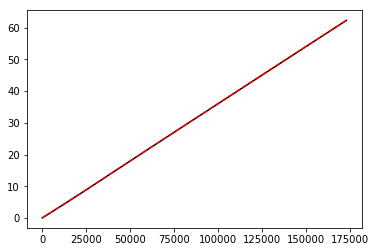

In [3]:
# Test 1: computation of potential energy from temperature profiles
casename = 'BF05WD05WV00'
turbmethod = 'KPP-CVMix'
# read potential energy in GOTM
infile_gotm = gotm_root+'/'+turbmethod+'/R7_'+casename+'/gotm_out.nc'
gdobj = GOTMOutputData(path=infile_gotm)
time_gotm = gdobj.time
epot_gotm = gdobj.read_timeseries('Epot').data

# starting index for the last inertial period
t0_gotm = time_gotm[-1]-Ti
tidx0_gotm = np.argmin(np.abs(time_gotm-t0_gotm))

# check the computation of potential energy
txym_gotm = gdobj.read_profile('temp')
bxym_gotm = txym_gotm.data*g*alpha
gdobj.open()
zu = gdobj.dataset.variables['z'][0,:,0,0]
zw = gdobj.dataset.variables['zi'][0,:,0,0]
zbot = zw[0]
dz = zw[1:]-zw[0:-1]
nt = time_gotm.size
epot2_gotm = np.zeros(nt)
for i in np.arange(nt):
    epot2_gotm[i] = np.sum(dz*bxym_gotm[i,:]*(zbot-zu))
epot2_gotm = epot2_gotm - epot2_gotm[0]
epot2_gotm = epot2_gotm*rho
plt.plot(time_gotm, epot_gotm, '-k')
plt.plot(time_gotm, epot2_gotm, '--r')


### Test 2

Then we show the changes of potential energy in all the LES cases here are approximately linear with time.

BF05WD05WV00
BF05WD05WV01
BF05WD05WV02
BF05WD05WV03
BF05WD05WV04
BF05WD08WV00
BF05WD08WV01
BF05WD08WV02
BF05WD08WV03
BF05WD08WV04
BF05WD10WV00
BF05WD10WV01
BF05WD10WV02
BF05WD10WV03
BF05WD10WV04
BF10WD05WV00
BF10WD05WV01
BF10WD05WV03
BF1hWD05WV00
BF1hWD05WV01
BF1hWD05WV03
BF1hWD08WV00
BF1hWD08WV01
BF1hWD08WV03
BF1hWD10WV00
BF1hWD10WV01
BF1hWD10WV03
BF25WD05WV00
BF25WD05WV01
BF25WD05WV03
BF25WD08WV00
BF25WD08WV01
BF25WD08WV03
BF25WD10WV00
BF25WD10WV01
BF25WD10WV03
BF2hWD05WV00
BF2hWD05WV01
BF2hWD05WV03
BF3hWD05WV00
BF3hWD05WV01
BF3hWD05WV03
BF50WD05WV00
BF50WD05WV01
BF50WD05WV03
BF50WD08WV00
BF50WD08WV01
BF50WD08WV03
BF50WD10WV00
BF50WD10WV01
BF50WD10WV03
BF5hWD05WV00
BF5hWD05WV01
BF5hWD05WV03


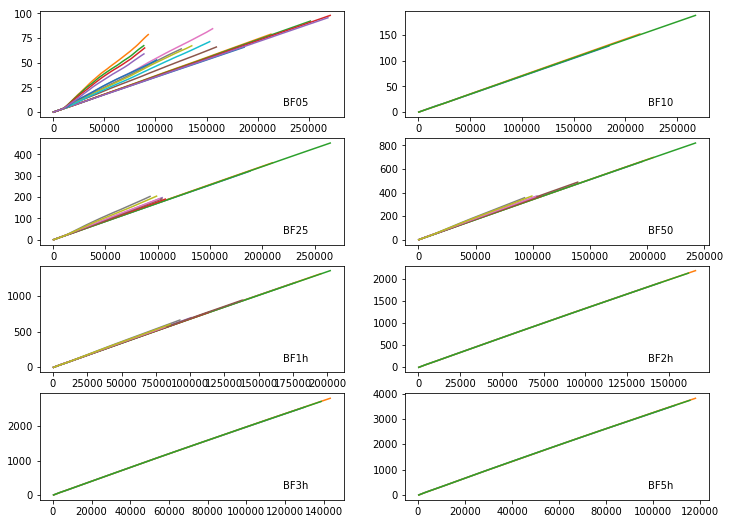

In [4]:
# Test 2: Check the change of potential energy in all the LES cases

f1, axarr = plt.subplots(4, 2)
f1.set_size_inches(12, 9)

axarr[0,0].text(0.8, 0.1, 'BF05', transform=axarr[0,0].transAxes)
axarr[0,1].text(0.8, 0.1, 'BF10', transform=axarr[0,1].transAxes)
axarr[1,0].text(0.8, 0.1, 'BF25', transform=axarr[1,0].transAxes)
axarr[1,1].text(0.8, 0.1, 'BF50', transform=axarr[1,1].transAxes)
axarr[2,0].text(0.8, 0.1, 'BF1h', transform=axarr[2,0].transAxes)
axarr[2,1].text(0.8, 0.1, 'BF2h', transform=axarr[2,1].transAxes)
axarr[3,0].text(0.8, 0.1, 'BF3h', transform=axarr[3,0].transAxes)
axarr[3,1].text(0.8, 0.1, 'BF5h', transform=axarr[3,1].transAxes)
for i in np.arange(nc):
    casename = casename_list[i]
    print(casename)

    # read potential energy in NCAR LES
    dir_les = lf17_root+'/R7_'+casename+'_ST00_ens01'
    fname_les = os.listdir(dir_les)[0]
    infile_les = dir_les+'/'+fname_les
    dataset = Dataset(infile_les, 'r')
    txym_les = dataset.variables['txym'][:,0,:]-273.
    bxym_les = txym_les*g*alpha
    zu_les = dataset.variables['z_u'][:]
    zw_les = dataset.variables['z_w'][:]
    time_les = dataset.variables['time'][:]
    zbot_les = zw_les[-1]
    dz_les = np.zeros(zu_les.size)
    dz_les[1:] = zw_les[0:-1]-zw_les[1:]
    dz_les[0] = 0-zw_les[0]
    nt_les = time_les.size
    epot_les = np.zeros(nt_les)
    for k in np.arange(nt_les):
        epot_les[k] = np.sum(dz_les*bxym_les[k,:]*(zbot_les-zu_les))

    epot_les = epot_les - epot_les[0]
    epot_les = epot_les*rho

    # starting index for the last inertial period
    t0_les = time_les[-1]-Ti
    tidx0_les = np.argmin(np.abs(time_les-t0_les))

    # plot timeseries for the potential energy in LES
    if 'BF05' in casename:
        axis = axarr[0,0]
    elif 'BF10' in casename:
        axis = axarr[0,1]
    elif 'BF25' in casename:
        axis = axarr[1,0]
    elif 'BF50' in casename:
        axis = axarr[1,1]
    elif 'BF1h' in casename:
        axis = axarr[2,0]
    elif 'BF2h' in casename:
        axis = axarr[2,1]
    elif 'BF3h' in casename:
        axis = axarr[3,0]
    elif 'BF5h' in casename:
        axis = axarr[3,1]
    else:
        print('Unsupported casename {}'.format(casename))
    axis.plot(time_les, epot_les)

### Rate of potential energy change in GOTM versus LES

Now we compute the ratio of potential energy change rate in GOTM over LES for all schemes.

In [5]:
# Compute the ratio of potential energy change rate in GOTM over LES

# loop over all cases
rpe = np.zeros([nc, nm])
s_les = np.zeros([nc, nm])
s_gotm = np.zeros([nc, nm])
hb = np.zeros(nc)
ustar = np.zeros(nc)
b0 = np.zeros(nc)
us0 = np.zeros(nc)
for i in np.arange(nc):
    casename = casename_list[i]
    print('Case name: {}'.format(casename))

    # read surface forcing conditions
    infile_les_s1 = lf17_s1_root+'/R7_'+casename+'_ST00_ens01/MeanProfile.mat'
    matdata_les = sio.loadmat(infile_les_s1)
    hb[i] = matdata_les['hb'][0]
    ustar[i] = matdata_les['utau'][0]
    b0[i] = matdata_les['wtsfc'][0]*g*alpha
    us0[i] = matdata_les['stokes'][0][0]
    
    # read potential energy in NCAR LES
    dir_les = lf17_root+'/R7_'+casename+'_ST00_ens01'
    fname_les = sorted(os.listdir(dir_les))[0]
    print(fname_les)
    infile_les = dir_les+'/'+fname_les
    dataset = Dataset(infile_les, 'r')
    txym_les = dataset.variables['txym'][:,0,:]-273.
    bxym_les = txym_les*g*alpha
    zu_les = dataset.variables['z_u'][:]
    zw_les = dataset.variables['z_w'][:]
    time_les = dataset.variables['time'][:]
    zbot_les = zw_les[-1]
    dz_les = np.zeros(zu_les.size)
    dz_les[1:] = zw_les[0:-1]-zw_les[1:]
    dz_les[0] = 0-zw_les[0]
    nt_les = time_les.size
    epot_les = np.zeros(nt_les)
    for k in np.arange(nt_les):
        epot_les[k] = np.sum(dz_les*bxym_les[k,:]*(zbot_les-zu_les))

    epot_les = epot_les - epot_les[0]
    epot_les = epot_les*rho

    # starting index for the last inertial period
    t0_les = time_les[-1]-Ti
    tidx0_les = np.argmin(np.abs(time_les-t0_les))

    # linear fit
    xx_les = time_les[tidx0_les:]-time_les[tidx0_les]
    yy_les = epot_les[tidx0_les:]-epot_les[tidx0_les]
    slope_les, intercept_les, r_value_les, p_value_les, std_err_les = stats.linregress(xx_les,yy_les)
    
    # loop over turbulent methods
    for j in np.arange(nm):
        turbmethod = turbmethod_list[j]
        print('  - Turbulence model: {}'.format(turbmethod))
        # read potential energy in GOTM
        infile_gotm = gotm_root+'/'+turbmethod+'/R7_'+casename+'/gotm_out.nc'
        gdobj = GOTMOutputData(path=infile_gotm)
        time_gotm = gdobj.time
        epot_gotm = gdobj.read_timeseries('Epot').data

        # starting index for the last inertial period
        t0_gotm = time_gotm[-1]-Ti
        tidx0_gotm = np.argmin(np.abs(time_gotm-t0_gotm))

        # linear fit
        xx_gotm = time_gotm[tidx0_gotm:]-time_gotm[tidx0_gotm]
        yy_gotm = epot_gotm[tidx0_gotm:]-epot_gotm[tidx0_gotm]
        slope_gotm, intercept_gotm, r_value_gotm, p_value_gotm, std_err_gotm = stats.linregress(xx_gotm,yy_gotm)
            
        # save the ratio
        rpe[i,j] = slope_gotm/slope_les
        s_les[i,j] = slope_les
        s_gotm[i,j] = slope_gotm

Case name: BF05WD05WV00
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF05WD05WV01
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF05WD05WV02
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbu

  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF1hWD08WV01
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF1hWD08WV03
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPP

  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF50WD05WV01
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPPLT-ENTR
  - Turbulence model: KPPLT-RWHGK
  - Turbulence model: EPBL-LT
  - Turbulence model: SMCLT
  - Turbulence model: OSMOSIS
Case name: BF50WD05WV03
his.mp.vis.000001.028801.nc
  - Turbulence model: KPP-CVMix
  - Turbulence model: KPP-ROMS
  - Turbulence model: EPBL
  - Turbulence model: SMC
  - Turbulence model: K-EPSILON-SG
  - Turbulence model: KPPLT-EFACTOR
  - Turbulence model: KPP

### Functions

In [6]:
def plot_hLL_dpedt(hLL, dpedt, axis=None, xlabel_on=True):
    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
    ax.plot(hLL, s_les[:,0], color='k', linewidth=1, linestyle=':', zorder=1)
    ax.scatter(hLL, s_les[:,0], color='gray', edgecolors='k', linewidth=1, zorder=2)
    ax.arrow(0.6, 0.2, 0.3, 0.48, width=0.006, color='lightgray', transform=ax.transAxes)
    ax.arrow(0.3, 0.25, -0.2, 0.1, width=0.006, color='black', transform=ax.transAxes)
    ax.arrow(0.6, 0.75, -0.25, 0.01, width=0.006, color='black', transform=ax.transAxes)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xlabel_on:
        ax.set_xlabel('$h/\kappa L$', fontsize=14)
    ax.set_ylabel('$d\mathrm{PE}/dt$', fontsize=14)
    ax.set_xlim([3e-3, 4e1])
    ax.set_ylim([2e-4, 5e-2])
    # set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
        
def plot_hLL_R(hLL, R, bcolor, legend_list, axis=None, xlabel_on=True):
    if axis is None:
        ax = plt.gca()
    else:
        ax = axis
    nm = len(legend_list)
    ax.axhline(y=1, linewidth=1, color='black')
    for i in np.arange(nm):
        ax.scatter(hLL, R[:,i], color=bcolor[i], edgecolors='k', linewidth=0.5, zorder=10)
    ax.set_xscale('log')
    ax.set_xlim([3e-3, 4e1])
    if xlabel_on:
        ax.set_xlabel('$h/L_L$', fontsize=14)
    ax.set_ylabel('$R$', fontsize=14)

    # set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)

    # legend
    xshift = 0.2
    xx = np.arange(nm)+1
    xx = xx*0.06+xshift
    yy = np.ones(xx.size)*0.1
    for i in np.arange(nm):
    #     ax.text(xx[i], yy[i], legend_list[i], color=bcolor[i], transform=ax.transAxes,
    #              fontsize=12, fontweight='bold', rotation=45, va='bottom', ha='left')
        ax.text(xx[i], yy[i], legend_list[i], color='black', transform=ax.transAxes,
                 fontsize=12, rotation=45, va='bottom', ha='left')
        ax.scatter(xx[i], 0.07, s=60, c=bcolor[i], edgecolors='k', linewidth=1, transform=ax.transAxes)


### $R$ versus $h/L_L$

Plot the ratio of the potential energy change rate in GOTM over LES. The ratio is plotted against the parameter $h/L_L$ to show the relative effects of Langmuir turbulence versus convection on entrainment.

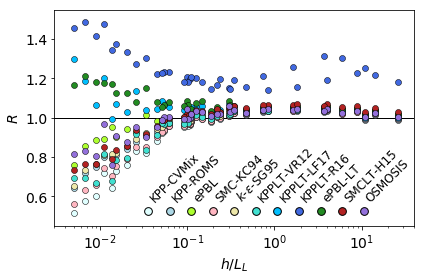

In [7]:
# get parameter h/L_L= w*^3/u*^2/u^s(0)
inds = us0==0
us0[inds] = np.nan
hLL = b0*hb/ustar**2/us0

f2 = plt.figure()
f2.set_size_inches(6, 4)

plot_hLL_R(hLL, rpe, bcolor, legend_list)

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_dPEdt_ratio_LF17.png'
plt.savefig(figname, dpi = 300)

### $d\mathrm{PE}/d t$ versus  $h/L_L$ in LES

To show the span of the rate of change in potential energy in LES. This figure shows the denominator of the ratios in the parameter space of $h/L_L$.

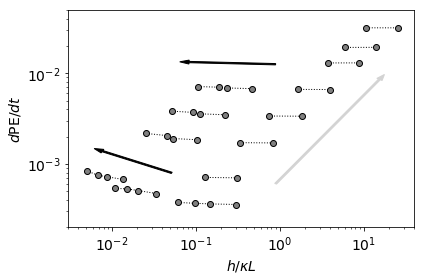

In [8]:
f3 = plt.figure()
f3.set_size_inches(6, 4)

plot_hLL_dpedt(hLL, s_les[:,0])

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_dPEdt_hLL_LF17.png'
plt.savefig(figname, dpi = 300)

### Two figures together

Two figures together for the paper.

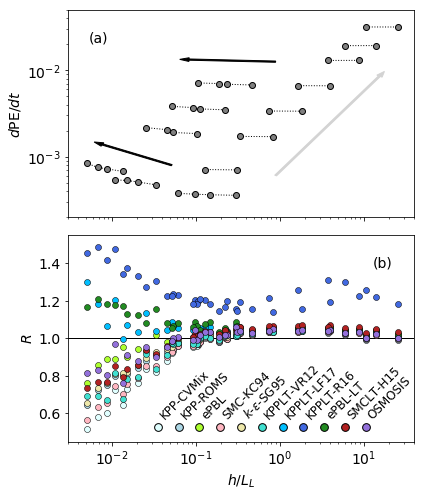

In [9]:
f4, axarr = plt.subplots(2, 1, sharex='col')
f4.set_size_inches(6, 7)
plot_hLL_dpedt(hLL, s_les[:,0], axis=axarr[0], xlabel_on=False)
plot_hLL_R(hLL, rpe, bcolor, legend_list, axis=axarr[1])
axarr[0].text(0.06, 0.9, '(a)', color='black', transform=axarr[0].transAxes,
             fontsize=14, va='top', ha='left')
axarr[1].text(0.88, 0.9, '(b)', color='black', transform=axarr[1].transAxes,
             fontsize=14, va='top', ha='left')
# reduce margin
plt.tight_layout()
# save figure
figname = fig_root+'/fig_dPEdt_cmp_LF17_all.png'
plt.savefig(figname, dpi = 300)

### $R$ versus $h/\kappa L$ 

Comparing this figure with the figure of $R$ versus $h/L_L$ shows that it is the relative importance of Langmuir turbulence (not wind) over convection that better distinguishes the behaviors of different schemes.

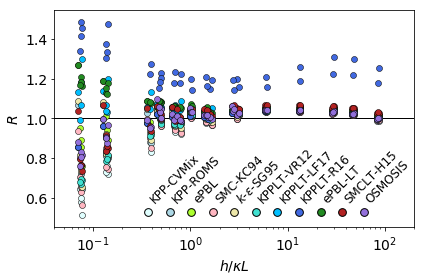

In [10]:
# plot the ratio of the rate of potential energy change in GOTM over LES

# get parameter h/(\kappa L)=w*^3/u*^3
hL = b0*hb/ustar**3

f5 = plt.figure()
f5.set_size_inches(6, 4)

plt.axhline(y=1, linewidth=1, color='black')
for i in np.arange(nm):
    plt.scatter(hL, rpe[:,i], color=bcolor[i], edgecolors='k', linewidth=0.5, zorder=10)
plt.xscale('log')
plt.xlabel('$h/\kappa L$', fontsize=14)
plt.ylabel('$R$', fontsize=14)
plt.xlim([4e-2, 2e2])

# set the tick labels font
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)

# legend
xshift = 0.2
xx = np.arange(nm)+1
xx = xx*0.06+xshift
yy = np.ones(xx.size)*0.1
for i in np.arange(nm):
    plt.text(xx[i], yy[i], legend_list[i], color='black', transform=ax.transAxes,
             fontsize=12, rotation=45, va='bottom', ha='left')
    plt.scatter(xx[i], 0.07, s=60, c=bcolor[i], edgecolors='k', linewidth=1, transform=ax.transAxes)

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/fig_dPEdt_cmp_x2_LF17.png'
plt.savefig(figname, dpi = 300)
